In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing # экспоненциальное сглаживание
from statsmodels.tsa.stattools import adfuller # проверка на стационарность ряда
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm # Для определения гиперпараметров модели

In [3]:
df22 = pd.read_csv('data/2022.csv')
df23 = pd.read_csv('data/2023.csv')
df24 = pd.read_csv('data/2024.csv')
df25 = pd.read_csv('data/2025.csv')

In [4]:
# Соединим таблицы 
df = pd.concat([df22,df23,df24,df25], ignore_index=True,axis=0)

# Сменим название
df.columns = ['Дата','1.P вых1','2.P вых2','3.Р вых','4.T вых','5.Т вх',"6.P вх",'7.Q мгн1','8.Q мгн2', '9.Q мгн сн', '10.Q сут1', '11.Q сут2', '712.Q сут сн', '13. Т воздуха']
# Выходные расходы по 2 ниткам суммируем в 1
df['Q мгн']= df['7.Q мгн1'] + df['8.Q мгн2']
df['Q сут'] = df['10.Q сут1'] + df['11.Q сут2']
# Удаляем лишние столбцы
df = df.drop(columns=['1.P вых1','2.P вых2','7.Q мгн1','8.Q мгн2','10.Q сут1','11.Q сут2'],axis=1)
# Снова переименуем
df.columns = ['Дата','Р вых','T вых','Т вх','P вх','Q мгн сн',"Q сут сн",'Т_воздуха','Q_мгн', 'Q сут']
# Дату приведем к формату
df['Дата'] = pd.to_datetime(df['Дата'])
# Подгрузим теплоемкость
df['год'] = df['Дата'].dt.year
df['месяц'] = df['Дата'].dt.month
heat_capacity_df = pd.read_excel('data/Q по Шакше.xlsx')
# Объединяем по году и месяцу
df = df.merge(heat_capacity_df, on=['год', 'месяц'], how='left')
df = df.drop(['год', 'месяц'], axis=1)

In [5]:
df = df[df['Дата']< '2025-10-01 00:00:00']

In [31]:
df.isna().sum()

Дата              0
Р вых           234
T вых           230
Т вх            230
P вх            235
Q мгн сн        345
Q сут сн        239
Т_воздуха       235
Q_мгн           301
Q сут           265
Теплоемкость      0
dtype: int64

In [6]:
df = df[['Дата','Q сут','Т_воздуха','Теплоемкость']]

In [7]:
df = df.set_index('Дата')
df['Q сут'] = df['Q сут'].round(0)
df["Т_воздуха"] = df["Т_воздуха"].round(1)
df['Теплоемкость'] = df['Теплоемкость'].round(0)

In [12]:
df[:500].to_csv('data/bf.csv')

In [34]:
df.isna().sum()

Q сут           265
Т_воздуха       235
Теплоемкость      0
dtype: int64

# Заполним пропуски

In [8]:
# Проверяем пропуски в значениях
print("Пропуски по столбцам:")
print(df.isna().sum())

# Для числовых столбцов используем интерполяцию
numeric_cols = ['Q сут', 'Т_воздуха']
for col in numeric_cols:
    # Линейная интерполяция для временного ряда
    df[col] = df[col].interpolate(method='linear')
    
    # Если остались пропуски в начале/конце, заполняем forward/backfill
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

print("\nПосле интерполяции:")
print(df.isna().sum())

Пропуски по столбцам:
Q сут           265
Т_воздуха       235
Теплоемкость      0
dtype: int64

После интерполяции:
Q сут           0
Т_воздуха       0
Теплоемкость    0
dtype: int64


## Сагрегируем данные по суткам

In [13]:
print("Информация о датафрейме:")
print(df.head())
print(f"Индекс: {df.index.name}")

# Создаем суточные данные
daily_data = []

# Получаем уникальные даты из индекса - ИСПРАВЛЕНИЕ ЗДЕСЬ
unique_dates = pd.Series(df.index.date).unique()

for i in range(len(unique_dates) - 1):
    current_date = unique_dates[i]
    next_date = unique_dates[i + 1]
    
    # Берем интервал с 13:00 текущего дня до 12:00 следующего дня
    start_time = pd.Timestamp.combine(current_date, pd.Timestamp('13:00:00').time())
    end_time = pd.Timestamp.combine(next_date, pd.Timestamp('13:00:00').time())
    
    mask = ((df.index >= start_time) & (df.index < end_time))
    
    day_data = df[mask]
    
    if len(day_data) > 0:
        # Берем значение Q_сут в 13:00 (первое значение в интервале)
        q_sut = day_data['Q сут'].iloc[0]
        
        # Считаем среднюю температуру за интервал
        avg_temp = day_data['Т_воздуха'].mean()
        
        # Теплоемкость (постоянная)
        heat_capacity = day_data['Теплоемкость'].iloc[0]
        
        daily_data.append({
            'date': current_date,
            'Q_сут': q_sut,
            'Т_воздуха_средняя': avg_temp,
            'Теплоемкость': heat_capacity
        })

# Создаем новый DataFrame с суточными данными
daily_df = pd.DataFrame(daily_data)
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')

print("\nСуточные данные:")
print(daily_df.head())
print(f"\nРазмерность суточных данных: {daily_df.shape}")

Информация о датафрейме:
                        Q сут  Т_воздуха  Теплоемкость
Дата                                                  
2022-01-01 00:00:00  736448.0       -7.5        8109.0
2022-01-01 01:00:00  736448.0       -7.6        8109.0
2022-01-01 02:00:00  736448.0       -7.6        8109.0
2022-01-01 03:00:00  736448.0       -7.7        8109.0
2022-01-01 04:00:00  736448.0       -8.0        8109.0
Индекс: Дата

Суточные данные:
               Q_сут  Т_воздуха_средняя  Теплоемкость
date                                                 
2022-01-01  692327.0          -6.195833        8109.0
2022-01-02  691338.0          -4.141667        8109.0
2022-01-03  660918.0         -11.550000        8109.0
2022-01-04  712526.0         -18.562500        8109.0
2022-01-05  748779.0         -24.616667        8109.0

Размерность суточных данных: (1368, 3)


In [14]:
daily_df

,Q_сут,Т_воздуха_средняя,Теплоемкость
date,,,
2022-01-01,692327.0,-6.195833,8109.0
2022-01-02,691338.0,-4.141667,8109.0
2022-01-03,660918.0,-11.550000,8109.0
2022-01-04,712526.0,-18.562500,8109.0
2022-01-05,748779.0,-24.616667,8109.0
...,...,...,...
2025-09-25,334711.0,6.370833,8340.0
2025-09-26,448448.0,6.545833,8340.0
2025-09-27,500589.0,4.554167,8340.0


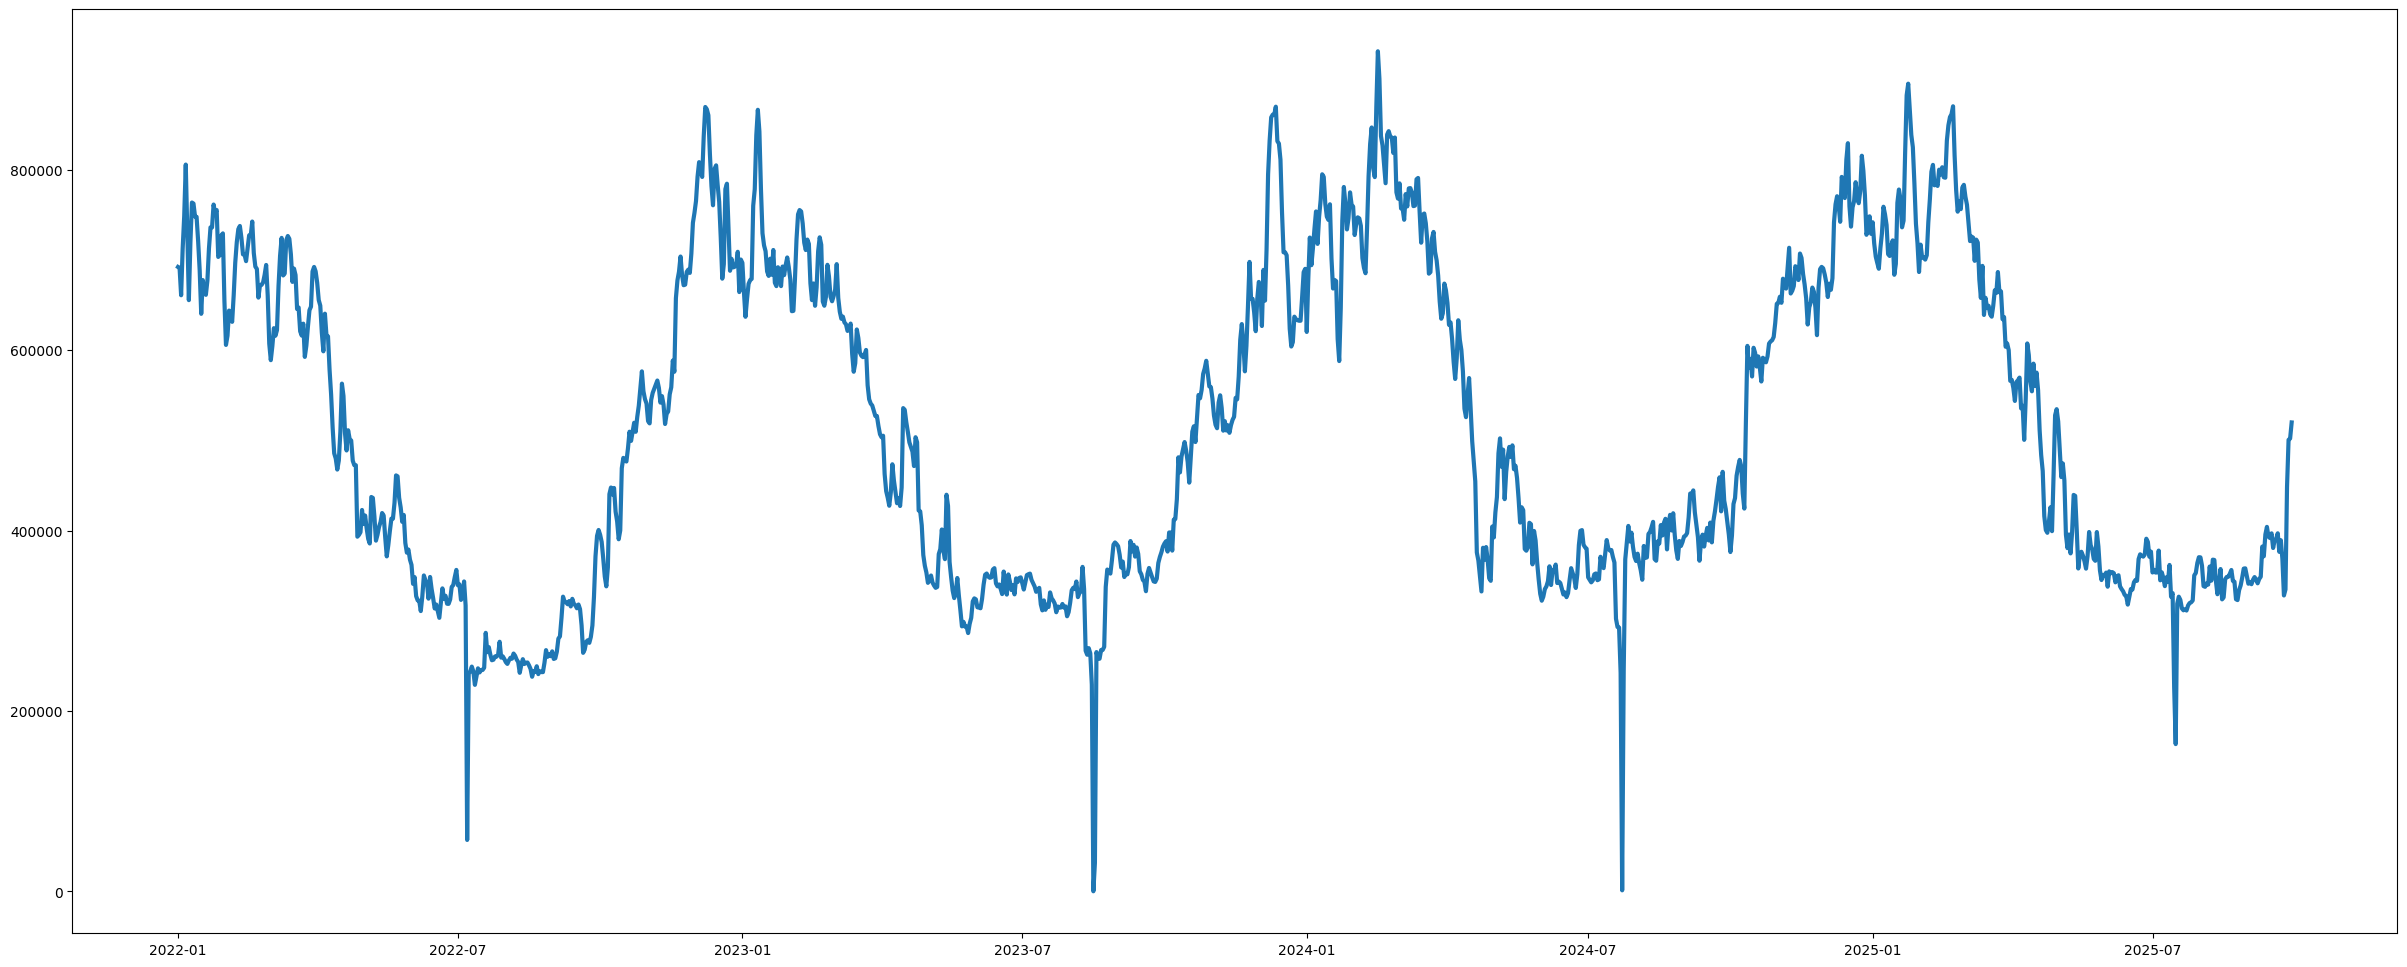

In [10]:
# Визуализация
plt.figure(figsize=(30, 12))
plt.plot(daily_df.index, daily_df['Q_сут'], linewidth=3)

## Проверка пропущенных значений

In [11]:
# Проверка непрерывности
print("Информация о временном ряде:")
print(f"Начало: {daily_df.index.min()}")
print(f"Конец: {daily_df.index.max()}")
print(f"Всего записей: {len(daily_df)}")

# Создаем полный временной диапазон
full_range = pd.date_range(start=daily_df.index.min(), end=daily_df.index.max(), freq='D')
print(f"Ожидаемое количество записей: {len(full_range)}")

# Находим пропущенные временные метки
missing_times = full_range.difference(daily_df.index)
print(f"Пропущенных временных меток: {len(missing_times)}")

if len(missing_times) > 0:
    print("\nПримеры пропущенных временных меток:")
    print(missing_times[:10])

Информация о временном ряде:
Начало: 2022-01-01 00:00:00
Конец: 2025-09-29 00:00:00
Всего записей: 1368
Ожидаемое количество записей: 1368
Пропущенных временных меток: 0


Созданные признаки (только лаги >= 8):
['Q_сут_lag_8', 'Q_сут_lag_9', 'Q_сут_lag_10', 'Q_сут_lag_11', 'Q_сут_lag_12', 'Q_сут_lag_13', 'Q_сут_lag_14', 'Q_сут_lag_15', 'Q_сут_lag_16', 'Q_сут_lag_17', 'Q_сут_lag_18', 'Q_сут_lag_19', 'Q_сут_lag_20', 'Q_сут_lag_21', 'Темп_lag_8', 'Темп_lag_9', 'Темп_lag_10', 'Темп_lag_11', 'Темп_lag_12', 'Темп_lag_13', 'Темп_lag_14', 'Темп_lag_15', 'Темп_lag_16', 'Темп_lag_17', 'Темп_lag_18', 'Темп_lag_19', 'Темп_lag_20', 'Темп_lag_21']

Размерность данных для недельного прогноза: (1347, 34)
Признаки: ['Т_воздуха_средняя', 'Теплоемкость', 'Q_сут_lag_8', 'Q_сут_lag_9', 'Q_сут_lag_10', 'Q_сут_lag_11', 'Q_сут_lag_12', 'Q_сут_lag_13', 'Q_сут_lag_14', 'Q_сут_lag_15', 'Q_сут_lag_16', 'Q_сут_lag_17', 'Q_сут_lag_18', 'Q_сут_lag_19', 'Q_сут_lag_20', 'Q_сут_lag_21', 'Темп_lag_8', 'Темп_lag_9', 'Темп_lag_10', 'Темп_lag_11', 'Темп_lag_12', 'Темп_lag_13', 'Темп_lag_14', 'Темп_lag_15', 'Темп_lag_16', 'Темп_lag_17', 'Темп_lag_18', 'Темп_lag_19', 'Темп_lag_20', 'Темп_lag_2

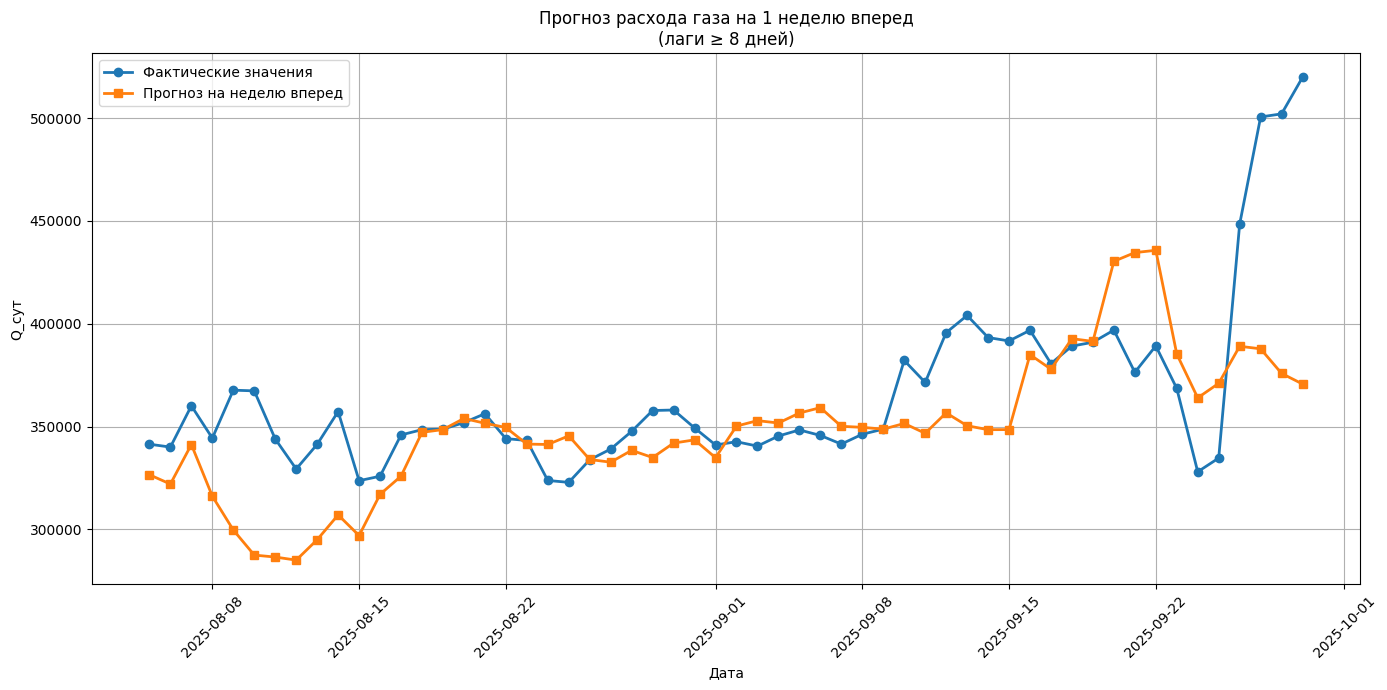


Важность признаков для недельного прогноза:
              feature  importance
16         Темп_lag_8    0.267432
0   Т_воздуха_средняя    0.213800
17         Темп_lag_9    0.178419
2         Q_сут_lag_8    0.101120
18        Темп_lag_10    0.094611
19        Темп_lag_11    0.032448
3         Q_сут_lag_9    0.026130
20        Темп_lag_12    0.017251
33       week_of_year    0.008598
4        Q_сут_lag_10    0.005480

Прогноз на следующую неделю (с 2025-09-30):
2025-09-30: 424398
2025-10-01: 393317
2025-10-02: 381441
2025-10-03: 399199
2025-10-04: 433412
2025-10-05: 446818
2025-10-06: 460389

Средняя ошибка по дням недели:
Вторник: 11963.98
Среда: 19313.68
Четверг: 19246.36
Пятница: 23770.37
Суббота: 38498.36
Воскресенье: 45139.71
Понедельник: 41206.87

Зависимость ошибки от дня прогноза (1-й день, 2-й день, etc.):
День 1: MAE = 11963.98
День 2: MAE = 19313.68
День 3: MAE = 19246.36
День 4: MAE = 23770.37
День 5: MAE = 38498.36
День 6: MAE = 45139.71
День 7: MAE = 41206.87


In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Создаем признаки с лагами больше 7 (для прогноза на неделю)
def create_features_weekly_forecast(df, target='Q_сут', min_lag=8, max_lag=21):
    """
    Создает признаки для прогноза на неделю вперед
    min_lag=8 - минимальный лаг (больше размера тестовой выборки=7)
    max_lag=21 - берем лаги за последние 3 недели
    """
    df = df.copy()
    
    # Лаговые значения целевой переменной (только лаги >= 8)
    for i in range(min_lag, max_lag + 1):
        df[f'Q_сут_lag_{i}'] = df[target].shift(i)
    
    # Лаговые значения температуры
    for i in range(min_lag, max_lag + 1):
        df[f'Темп_lag_{i}'] = df['Т_воздуха_средняя'].shift(i)
    
    # Временные признаки
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['month'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week
    
    return df

# Создаем признаки для недельного прогноза
daily_df_weekly = create_features_weekly_forecast(daily_df, min_lag=8, max_lag=21)
daily_df_weekly = daily_df_weekly.dropna()

print("Созданные признаки (только лаги >= 8):")
print([col for col in daily_df_weekly.columns if 'lag' in col])

# Разделяем на признаки и целевую переменную (НЕ удаляем Теплоемкость!)
X_weekly = daily_df_weekly.drop(['Q_сут'], axis=1)  # Оставляем Теплоемкость как признак
y_weekly = daily_df_weekly['Q_сут']

print(f"\nРазмерность данных для недельного прогноза: {X_weekly.shape}")
print(f"Признаки: {X_weekly.columns.tolist()}")

# Обучаем модель
model_weekly = RandomForestRegressor(n_estimators=100, random_state=42)
model_weekly.fit(X_weekly, y_weekly)

# Функция для прогноза на неделю вперед
def forecast_next_week(model, last_known_data, forecast_date):
    """
    Прогнозирует расход газа на следующую неделю
    
    Parameters:
    - model: обученная модель
    - last_known_data: последние известные данные (DataFrame)
    - forecast_date: дата, с которой начинается прогноз
    """
    
    predictions = {}
    
    # Для каждого дня недели создаем признаки и делаем прогноз
    for day in range(7):
        current_date = forecast_date + pd.Timedelta(days=day)
        
        # Создаем признаки для этого дня
        features = {}
        
        # Лаги расхода газа (из последних известных данных)
        for lag in range(8, 22):  # лаги с 8 по 21
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Q_сут_lag_{lag}'] = last_known_data.loc[lag_date, 'Q_сут']
            else:
                # Если данных нет, используем ближайшее доступное
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Q_сут_lag_{lag}'] = last_known_data.loc[nearest_date, 'Q_сут']
                else:
                    features[f'Q_сут_lag_{lag}'] = last_known_data['Q_сут'].mean()
        
        # Лаги температуры (в реальности нужно использовать прогноз погоды)
        for lag in range(8, 22):
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Темп_lag_{lag}'] = last_known_data.loc[lag_date, 'Т_воздуха_средняя']
            else:
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Темп_lag_{lag}'] = last_known_data.loc[nearest_date, 'Т_воздуха_средняя']
                else:
                    features[f'Темп_lag_{lag}'] = last_known_data['Т_воздуха_средняя'].mean()
        
        # Временные признаки (известны заранее)
        features['day_of_week'] = current_date.dayofweek
        features['is_weekend'] = 1 if current_date.dayofweek in [5, 6] else 0
        features['month'] = current_date.month
        features['week_of_year'] = current_date.isocalendar().week
        
        # Теплоемкость - используем последнее известное значение
        # (предполагаем, что она не меняется в течение недели)
        features['Теплоемкость'] = last_known_data['Теплоемкость'].iloc[-1]
        
        # Текущая температура - в реальности нужно использовать прогноз
        # Пока используем среднюю за последнюю неделю как приближение
        features['Т_воздуха_средняя'] = last_known_data['Т_воздуха_средняя'].tail(7).mean()
        
        # Создаем DataFrame с правильным порядком признаков
        features_df = pd.DataFrame([features])[X_weekly.columns]
        
        # Прогнозируем
        prediction = model.predict(features_df)[0]
        predictions[current_date] = prediction
    
    return predictions

# Тестируем модель на исторических данных
def evaluate_weekly_forecast(model, X, y, test_weeks=4):
    """
    Оценка модели на исторических данных с прогнозом на неделю вперед
    """
    all_predictions = []
    all_actuals = []
    dates = []
    
    # Берем несколько недель для тестирования
    test_start = len(X) - test_weeks * 7
    
    for week_start in range(test_start, len(X), 7):
        if week_start + 7 > len(X):
            break
            
        # Данные для прогноза
        forecast_date = X.index[week_start]
        last_known_data = daily_df.loc[:forecast_date - pd.Timedelta(days=1)]
        
        # Получаем прогноз на неделю
        week_predictions = forecast_next_week(model, last_known_data, forecast_date)
        
        # Собираем фактические значения
        for date, pred in week_predictions.items():
            if date in y.index:
                all_predictions.append(pred)
                all_actuals.append(y.loc[date])
                dates.append(date)
    
    return np.array(all_actuals), np.array(all_predictions), dates

# Оцениваем модель
actuals, predictions, dates = evaluate_weekly_forecast(model_weekly, X_weekly, y_weekly, test_weeks=8)

# Качество прогноза
mae_weekly = mean_absolute_error(actuals, predictions)
rmse_weekly = np.sqrt(mean_squared_error(actuals, predictions))

print(f"\nКачество недельного прогноза:")
print(f"MAE: {mae_weekly:.2f}")
print(f"RMSE: {rmse_weekly:.2f}")

# Визуализируем результаты
plt.figure(figsize=(14, 7))
plt.plot(dates, actuals, label='Фактические значения', linewidth=2, marker='o')
plt.plot(dates, predictions, label='Прогноз на неделю вперед', linewidth=2, marker='s')
plt.xlabel('Дата')
plt.ylabel('Q_сут')
plt.title('Прогноз расхода газа на 1 неделю вперед\n(лаги ≥ 8 дней)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ важности признаков для недельного прогноза
feature_importance_weekly = pd.DataFrame({
    'feature': X_weekly.columns,
    'importance': model_weekly.feature_importances_
}).sort_values('importance', ascending=False)

print("\nВажность признаков для недельного прогноза:")
print(feature_importance_weekly.head(10))

# Пример прогноза на следующую неделю (используя последние доступные данные)
last_known_date = X_weekly.index[-1]
next_week_start = last_known_date + pd.Timedelta(days=1)
next_week_predictions = forecast_next_week(model_weekly, daily_df, next_week_start)

print(f"\nПрогноз на следующую неделю (с {next_week_start.date()}):")
for date, pred in next_week_predictions.items():
    print(f"{date.date()}: {pred:.0f}")

# Дополнительный анализ: как ошибка меняется по дням недели
error_by_day = {}
day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

for i, date in enumerate(dates):
    day_of_week = date.weekday()
    day_name = day_names[day_of_week]
    error = abs(actuals[i] - predictions[i])
    if day_name not in error_by_day:
        error_by_day[day_name] = []
    error_by_day[day_name].append(error)

print("\nСредняя ошибка по дням недели:")
for day, errors in error_by_day.items():
    print(f"{day}: {np.mean(errors):.2f}")

# Анализ зависимости ошибки от горизонта прогноза
print("\nЗависимость ошибки от дня прогноза (1-й день, 2-й день, etc.):")
for day_in_week in range(7):
    day_errors = []
    for i in range(day_in_week, len(predictions), 7):
        if i < len(predictions):
            day_errors.append(abs(actuals[i] - predictions[i]))
    if day_errors:
        print(f"День {day_in_week + 1}: MAE = {np.mean(day_errors):.2f}")

Последняя дата в данных: 2025-09-29
Прогнозируем неделю с 2025-09-23 по 2025-09-29

Температуры, используемые как 'прогноз':
2025-09-23: 20.2°C
2025-09-24: 15.5°C
2025-09-25: 6.4°C
2025-09-26: 6.5°C
2025-09-27: 4.6°C
2025-09-28: 3.4°C
2025-09-29: -0.1°C

Дата         |    Прогноз |       Факт |     Ошибка |  Отн. ошибка
-----------------------------------------------------------------
2025-09-23 |     365364 |     368577 |       3213 |        0.9%
2025-09-24 |     352545 |     328033 |      24512 |        7.5%
2025-09-25 |     378996 |     334711 |      44285 |       13.2%
2025-09-26 |     450353 |     448448 |       1905 |        0.4%
2025-09-27 |     486690 |     500589 |      13899 |        2.8%
2025-09-28 |     496848 |     502096 |       5248 |        1.0%
2025-09-29 |     496194 |     519884 |      23690 |        4.6%

Метрики качества прогноза:
MAE:  16679
RMSE: 21902
MAPE: 4.3%


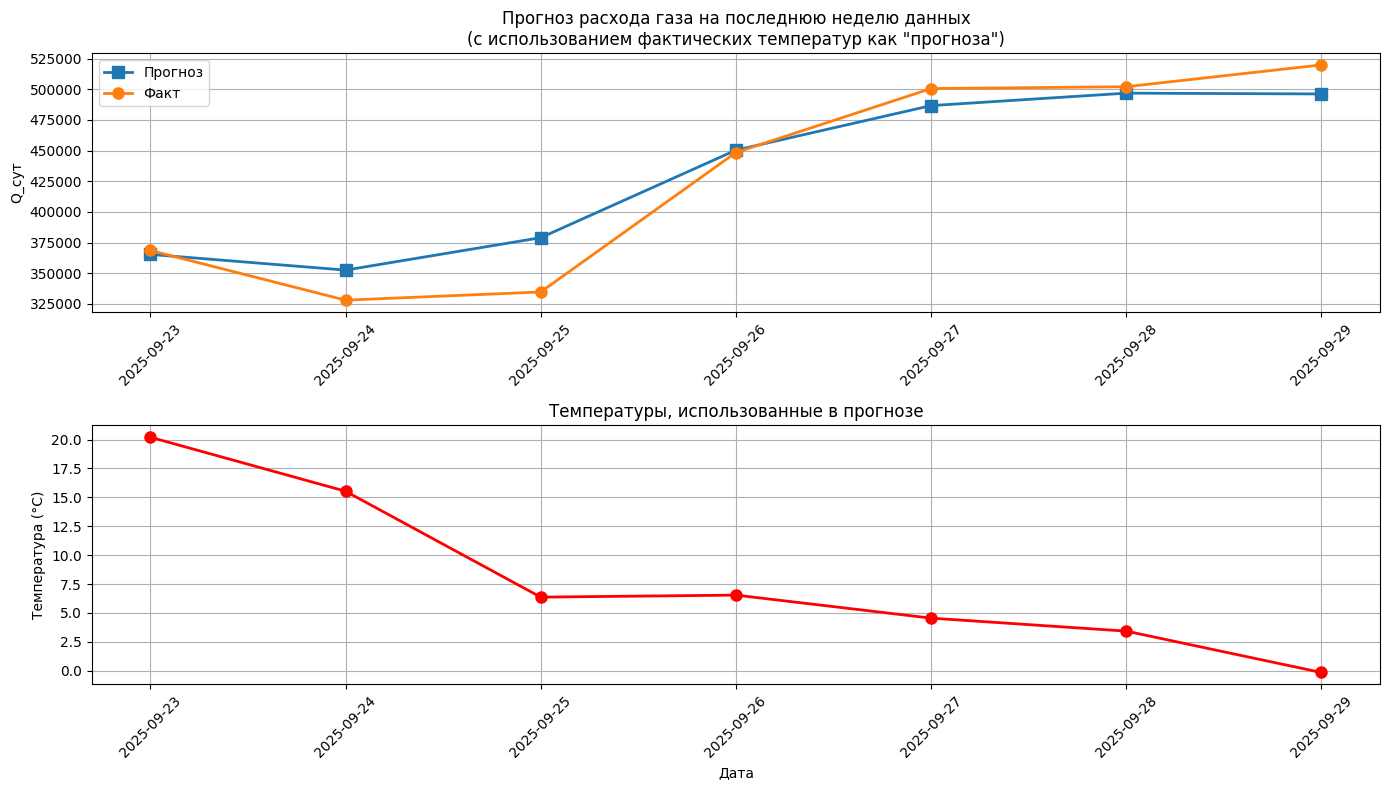


Анализ трендов:
Фактическое изменение за неделю: +151307
Прогнозируемое изменение за неделю: +130830
Ошибка в тренде: 20477

Средняя ошибка по дням:
Будни: 19521
Выходные: 9574


In [17]:
# Функция для прогноза на неделю с использованием известных температур
def forecast_next_week_with_known_temps(model, last_known_data, forecast_date, temperature_forecasts):
    """
    Прогнозирует расход газа на следующую неделю с использованием известных температур
    
    Parameters:
    -----------
    model : sklearn model
        Обученная модель машинного обучения
    last_known_data : pandas DataFrame
        Исторические данные
    forecast_date : datetime или str
        Дата, с которой начинается прогноз
    temperature_forecasts : dict или pandas Series
        Прогнозы температуры на 7 дней вперед {дата: температура}
    
    Returns:
    --------
    predictions : dict
        Словарь с прогнозами {дата: прогноз}
    """
    
    predictions = {}
    
    # Преобразуем forecast_date в pandas Timestamp если нужно
    if isinstance(forecast_date, str):
        forecast_date = pd.Timestamp(forecast_date)
    
    # Для каждого дня недели создаем признаки и делаем прогноз
    for day in range(7):
        current_date = forecast_date + pd.Timedelta(days=day)
        
        # Создаем признаки для этого дня
        features = {}
        
        # Лаги расхода газа (из последних известных данных)
        for lag in range(8, 22):  # лаги с 8 по 21 день
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Q_сут_lag_{lag}'] = last_known_data.loc[lag_date, 'Q_сут']
            else:
                # Если данных нет, используем ближайшее доступное
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Q_сут_lag_{lag}'] = last_known_data.loc[nearest_date, 'Q_сут']
                else:
                    features[f'Q_сут_lag_{lag}'] = last_known_data['Q_сут'].mean()
        
        # Лаги температуры
        for lag in range(8, 22):
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Темп_lag_{lag}'] = last_known_data.loc[lag_date, 'Т_воздуха_средняя']
            else:
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Темп_lag_{lag}'] = last_known_data.loc[nearest_date, 'Т_воздуха_средняя']
                else:
                    features[f'Темп_lag_{lag}'] = last_known_data['Т_воздуха_средняя'].mean()
        
        # Временные признаки (известны заранее)
        features['day_of_week'] = current_date.dayofweek
        features['is_weekend'] = 1 if current_date.dayofweek in [5, 6] else 0
        features['month'] = current_date.month
        features['week_of_year'] = current_date.isocalendar().week
        
        # Теплоемкость - используем последнее известное значение
        features['Теплоемкость'] = last_known_data['Теплоемкость'].iloc[-1]
        
        # Текущая температура - используем "прогноз" (фактическую температуру)
        features['Т_воздуха_средняя'] = temperature_forecasts[current_date]
        
        # Создаем DataFrame с правильным порядком признаков
        features_df = pd.DataFrame([features])[model.feature_names_in_]
        
        # Прогнозируем
        prediction = model.predict(features_df)[0]
        predictions[current_date] = prediction
    
    return predictions

# Получаем последние даты из наших данных
last_date = daily_df.index[-1]
week_start = last_date - pd.Timedelta(days=6)  # Начинаем за 7 дней до конца

print(f"Последняя дата в данных: {last_date.strftime('%Y-%m-%d')}")
print(f"Прогнозируем неделю с {week_start.strftime('%Y-%m-%d')} по {last_date.strftime('%Y-%m-%d')}")

# Создаем словарь с фактическими температурами на эту неделю (как будто это прогноз)
temperature_forecasts = {}
for day in range(7):
    current_date = week_start + pd.Timedelta(days=day)
    if current_date in daily_df.index:
        temperature_forecasts[current_date] = daily_df.loc[current_date, 'Т_воздуха_средняя']

print("\nТемпературы, используемые как 'прогноз':")
for date, temp in temperature_forecasts.items():
    print(f"{date.strftime('%Y-%m-%d')}: {temp:.1f}°C")

# Данные, известные до начала прогноза
data_before_week = daily_df.loc[:week_start - pd.Timedelta(days=1)]

# Делаем прогноз
predictions = forecast_next_week_with_known_temps(
    model_weekly, 
    data_before_week, 
    week_start, 
    temperature_forecasts
)

# Собираем фактические значения для сравнения
actual_values = {}
for date in predictions.keys():
    if date in daily_df.index:
        actual_values[date] = daily_df.loc[date, 'Q_сут']

# Сравниваем прогноз с фактическими значениями
print(f"\n{'Дата':12} | {'Прогноз':>10} | {'Факт':>10} | {'Ошибка':>10} | {'Отн. ошибка':>12}")
print("-" * 65)
total_error = 0
for date in sorted(predictions.keys()):
    pred = predictions[date]
    actual = actual_values.get(date, None)
    if actual is not None:
        error = abs(pred - actual)
        rel_error = (error / actual) * 100
        total_error += error
        print(f"{date.strftime('%Y-%m-%d')} | {pred:10.0f} | {actual:10.0f} | {error:10.0f} | {rel_error:10.1f}%")
    else:
        print(f"{date.strftime('%Y-%m-%d')} | {pred:10.0f} | {'N/A':>10} | {'N/A':>10} | {'N/A':>12}")

# Считаем метрики качества
if actual_values:
    pred_list = [predictions[date] for date in sorted(predictions.keys()) if date in actual_values]
    actual_list = [actual_values[date] for date in sorted(predictions.keys()) if date in actual_values]
    
    mae = mean_absolute_error(actual_list, pred_list)
    rmse = np.sqrt(mean_squared_error(actual_list, pred_list))
    mape = np.mean(np.abs((np.array(actual_list) - np.array(pred_list)) / np.array(actual_list))) * 100
    
    print(f"\nМетрики качества прогноза:")
    print(f"MAE:  {mae:.0f}")
    print(f"RMSE: {rmse:.0f}")
    print(f"MAPE: {mape:.1f}%")

# Визуализируем результаты
plt.figure(figsize=(14, 8))

# График расхода газа
plt.subplot(2, 1, 1)
dates_list = sorted(predictions.keys())
preds_list = [predictions[date] for date in dates_list]
actuals_list = [actual_values.get(date, None) for date in dates_list]

plt.plot(dates_list, preds_list, 's-', label='Прогноз', linewidth=2, markersize=8)
plt.plot(dates_list, actuals_list, 'o-', label='Факт', linewidth=2, markersize=8)

plt.title('Прогноз расхода газа на последнюю неделю данных\n(с использованием фактических температур как "прогноза")')
plt.ylabel('Q_сут')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# График температур
plt.subplot(2, 1, 2)
temps_list = [temperature_forecasts[date] for date in dates_list]
plt.plot(dates_list, temps_list, 'o-', color='red', linewidth=2, markersize=8)
plt.title('Температуры, использованные в прогнозе')
plt.ylabel('Температура (°C)')
plt.xlabel('Дата')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Анализ трендов
print("\nАнализ трендов:")
trend_actual = actual_list[-1] - actual_list[0]
trend_pred = pred_list[-1] - pred_list[0]
print(f"Фактическое изменение за неделю: {trend_actual:+.0f}")
print(f"Прогнозируемое изменение за неделю: {trend_pred:+.0f}")
print(f"Ошибка в тренде: {abs(trend_actual - trend_pred):.0f}")

# Проверка, как модель справляется с разными типами дней
weekend_dates = [date for date in predictions.keys() if date.weekday() >= 5]
weekday_dates = [date for date in predictions.keys() if date.weekday() < 5]

if weekend_dates and weekday_dates:
    weekend_error = np.mean([abs(predictions[date] - actual_values[date]) for date in weekend_dates])
    weekday_error = np.mean([abs(predictions[date] - actual_values[date]) for date in weekday_dates])
    
    print(f"\nСредняя ошибка по дням:")
    print(f"Будни: {weekday_error:.0f}")
    print(f"Выходные: {weekend_error:.0f}")

In [33]:
(daily_df.loc['2022-09-23']['Q_сут']+daily_df.loc['2023-09-23']['Q_сут']+daily_df.loc['2024-09-23']['Q_сут'])/3

358323.3333333333

In [32]:
daily_df.loc['2025-09-23']['Q_сут']

368577.0

In [ ]:
365364 

In [18]:
temperature_forecasts

{Timestamp('2025-09-23 00:00:00'): 20.2,
 Timestamp('2025-09-24 00:00:00'): 15.529166666666667,
 Timestamp('2025-09-25 00:00:00'): 6.370833333333334,
 Timestamp('2025-09-26 00:00:00'): 6.545833333333333,
 Timestamp('2025-09-27 00:00:00'): 4.554166666666666,
 Timestamp('2025-09-28 00:00:00'): 3.4312500000000004,
 Timestamp('2025-09-29 00:00:00'): -0.14583333333333334}

In [19]:
data_before_week

,Q_сут,Т_воздуха_средняя,Теплоемкость
date,,,
2022-01-01,692327.0,-6.195833,8109.0
2022-01-02,691338.0,-4.141667,8109.0
2022-01-03,660918.0,-11.550000,8109.0
2022-01-04,712526.0,-18.562500,8109.0
2022-01-05,748779.0,-24.616667,8109.0
...,...,...,...
2025-09-18,389168.0,14.895833,8340.0
2025-09-19,391027.0,15.037500,8340.0
2025-09-20,396938.0,14.850000,8340.0


Прогнозируем неделю с 2025-09-23 по 2025-09-29

Прогноз с теплоемкостью 8340:
Дата         |    Прогноз |       Факт |     Ошибка
-------------------------------------------------------
2025-09-23 |     365364 |     368577 |       3213
2025-09-24 |     352545 |     328033 |      24512
2025-09-25 |     378996 |     334711 |      44285
2025-09-26 |     450353 |     448448 |       1905
2025-09-27 |     486690 |     500589 |      13899
2025-09-28 |     496848 |     502096 |       5248
2025-09-29 |     496194 |     519884 |      23690

ПРИМЕР ПРОГНОЗА ДЛЯ БУДУЩЕГО ПЕРИОДА

Прогноз на неделю с 2025-09-01:
Теплоемкость: 8340
Дата         |  Температура |  Прогноз Q_сут
---------------------------------------------
2025-09-01 |         15.0°C |         352772
2025-09-02 |         16.0°C |         350249
2025-09-03 |         14.0°C |         359284
2025-09-04 |         13.0°C |         369201
2025-09-05 |         12.0°C |         374805
2025-09-06 |         11.0°C |         373984
2025-09-07 | 

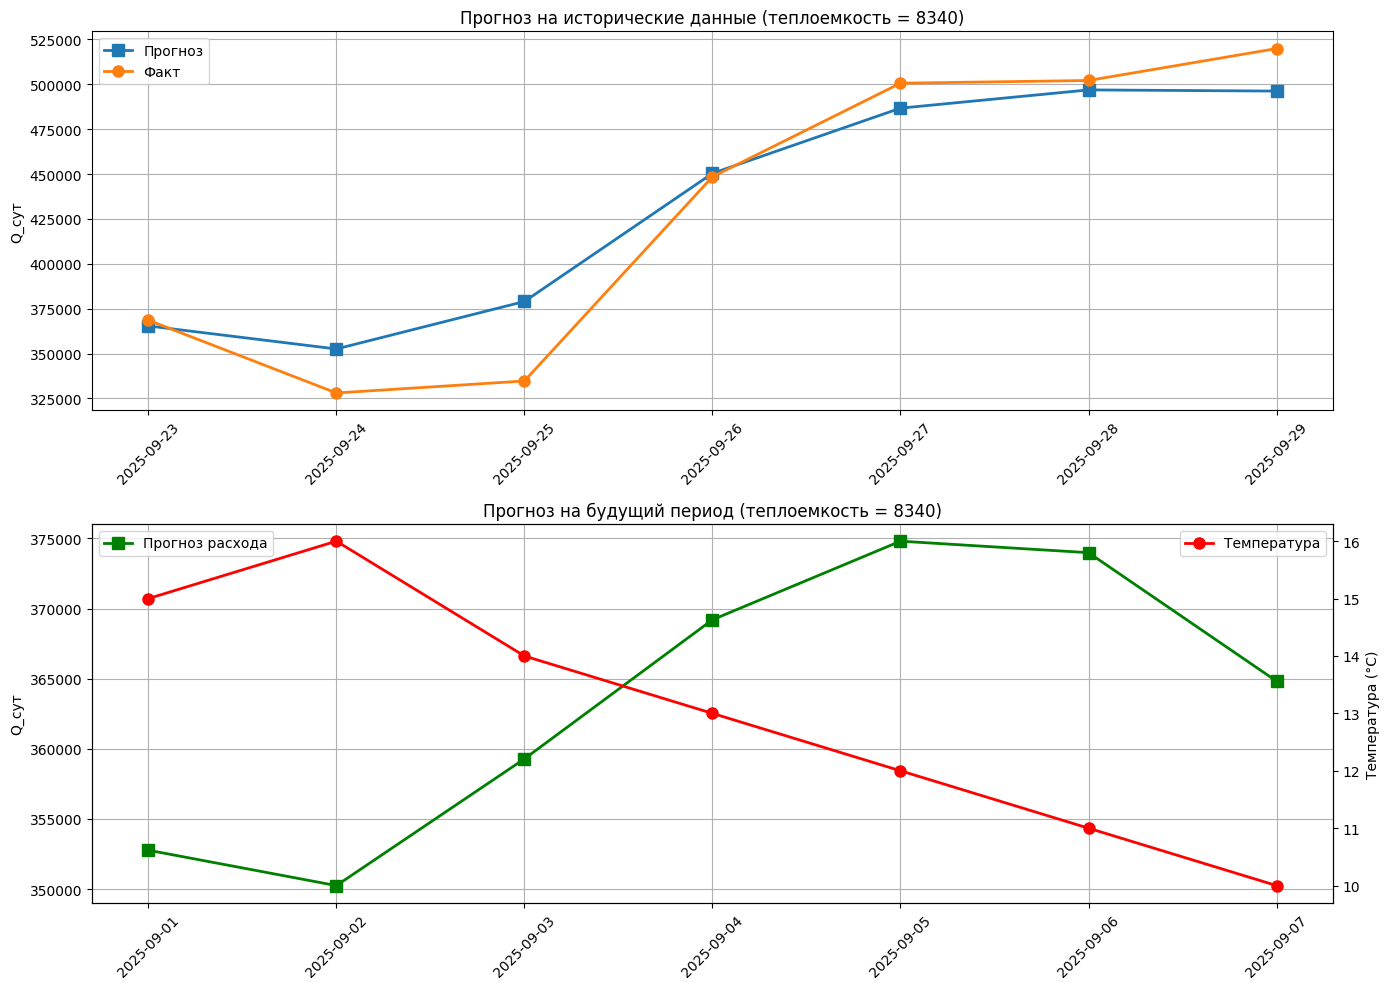


ПРИМЕР БЫСТРОГО ПРОГНОЗА

Прогноз на неделю с 2025-09-01:
Теплоемкость: 7950.0
Дата         |  Температура |  Прогноз Q_сут
---------------------------------------------
2025-09-01 |         15.0°C |         355939
2025-09-02 |         16.0°C |         354101
2025-09-03 |         14.0°C |         360668
2025-09-04 |         13.0°C |         368183
2025-09-05 |         12.0°C |         371615
2025-09-06 |         11.0°C |         371929
2025-09-07 |         10.0°C |         365342


{Timestamp('2025-09-01 00:00:00'): 355938.81,
 Timestamp('2025-09-02 00:00:00'): 354101.16,
 Timestamp('2025-09-03 00:00:00'): 360667.93,
 Timestamp('2025-09-04 00:00:00'): 368182.67,
 Timestamp('2025-09-05 00:00:00'): 371615.03,
 Timestamp('2025-09-06 00:00:00'): 371929.41,
 Timestamp('2025-09-07 00:00:00'): 365342.1}

In [23]:
def forecast_next_week_with_custom_params(model, last_known_data, forecast_date, temperature_forecasts, heat_capacity):
    """
    Прогнозирует расход газа на следующую неделю с использованием заданных параметров
    
    Parameters:
    -----------
    model : sklearn model
        Обученная модель машинного обучения
    last_known_data : pandas DataFrame
        Исторические данные
    forecast_date : datetime или str
        Дата, с которой начинается прогноз
    temperature_forecasts : dict или pandas Series
        Прогнозы температуры на 7 дней вперед {дата: температура}
    heat_capacity : float
        Теплоемкость для прогнозируемого периода
    
    Returns:
    --------
    predictions : dict
        Словарь с прогнозами {дата: прогноз}
    """
    
    predictions = {}
    
    # Преобразуем forecast_date в pandas Timestamp если нужно
    if isinstance(forecast_date, str):
        forecast_date = pd.Timestamp(forecast_date)
    
    # Для каждого дня недели создаем признаки и делаем прогноз
    for day in range(7):
        current_date = forecast_date + pd.Timedelta(days=day)
        
        # Создаем признаки для этого дня
        features = {}
        
        # Лаги расхода газа (из последних известных данных)
        for lag in range(8, 22):  # лаги с 8 по 21 день
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Q_сут_lag_{lag}'] = last_known_data.loc[lag_date, 'Q_сут']
            else:
                # Если данных нет, используем ближайшее доступное
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Q_сут_lag_{lag}'] = last_known_data.loc[nearest_date, 'Q_сут']
                else:
                    features[f'Q_сут_lag_{lag}'] = last_known_data['Q_сут'].mean()
        
        # Лаги температуры
        for lag in range(8, 22):
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Темп_lag_{lag}'] = last_known_data.loc[lag_date, 'Т_воздуха_средняя']
            else:
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Темп_lag_{lag}'] = last_known_data.loc[nearest_date, 'Т_воздуха_средняя']
                else:
                    features[f'Темп_lag_{lag}'] = last_known_data['Т_воздуха_средняя'].mean()
        
        # Временные признаки (известны заранее)
        features['day_of_week'] = current_date.dayofweek
        features['is_weekend'] = 1 if current_date.dayofweek in [5, 6] else 0
        features['month'] = current_date.month
        features['week_of_year'] = current_date.isocalendar().week
        
        # Теплоемкость - используем заданное пользователем значение
        features['Теплоемкость'] = heat_capacity
        
        # Текущая температура - используем "прогноз" (фактическую температуру)
        features['Т_воздуха_средняя'] = temperature_forecasts[current_date]
        
        # Создаем DataFrame с правильным порядком признаков
        features_df = pd.DataFrame([features])[model.feature_names_in_]
        
        # Прогнозируем
        prediction = model.predict(features_df)[0]
        predictions[current_date] = prediction
    
    return predictions

# Пример использования для прогноза на последнюю неделю данных
last_date = daily_df.index[-1]
week_start = last_date - pd.Timedelta(days=6)

print(f"Прогнозируем неделю с {week_start.strftime('%Y-%m-%d')} по {last_date.strftime('%Y-%m-%d')}")

# Создаем словарь с фактическими температурами на эту неделю
temperature_forecasts = {}
for day in range(7):
    current_date = week_start + pd.Timedelta(days=day)
    if current_date in daily_df.index:
        temperature_forecasts[current_date] = daily_df.loc[current_date, 'Т_воздуха_средняя']

# Данные, известные до начала прогноза
data_before_week = daily_df.loc[:week_start - pd.Timedelta(days=1)]

# ЗАДАЕМ ТЕПЛОЕМКОСТЬ ВРУЧНУЮ
# Например, для сентября 2025 года мы знаем, что теплоемкость будет 7950.0
heat_capacity_september_2025 = 8340

# Делаем прогноз с заданной теплоемкостью
predictions = forecast_next_week_with_custom_params(
    model_weekly, 
    data_before_week, 
    week_start, 
    temperature_forecasts,
    heat_capacity_september_2025  # передаем конкретное значение теплоемкости
)

# Собираем фактические значения для сравнения
actual_values = {}
for date in predictions.keys():
    if date in daily_df.index:
        actual_values[date] = daily_df.loc[date, 'Q_сут']

# Выводим результаты
print(f"\nПрогноз с теплоемкостью {heat_capacity_september_2025}:")
print(f"{'Дата':12} | {'Прогноз':>10} | {'Факт':>10} | {'Ошибка':>10}")
print("-" * 55)
for date in sorted(predictions.keys()):
    pred = predictions[date]
    actual = actual_values.get(date, None)
    if actual is not None:
        error = abs(pred - actual)
        print(f"{date.strftime('%Y-%m-%d')} | {pred:10.0f} | {actual:10.0f} | {error:10.0f}")
    else:
        print(f"{date.strftime('%Y-%m-%d')} | {pred:10.0f} | {'N/A':>10} | {'N/A':>10}")

# Пример прогноза для будущего периода
print("\n" + "="*60)
print("ПРИМЕР ПРОГНОЗА ДЛЯ БУДУЩЕГО ПЕРИОДА")
print("="*60)

# Предположим, мы хотим спрогнозировать на неделю с 1 сентября 2025 года
future_week_start = pd.Timestamp('2025-09-01')

# Предполагаемые прогнозы температуры на эту неделю (например, из метеосервиса)
future_temperature_forecasts = {
    pd.Timestamp('2025-09-01'): 15.0,
    pd.Timestamp('2025-09-02'): 16.0,
    pd.Timestamp('2025-09-03'): 14.0,
    pd.Timestamp('2025-09-04'): 13.0,
    pd.Timestamp('2025-09-05'): 12.0,
    pd.Timestamp('2025-09-06'): 11.0,
    pd.Timestamp('2025-09-07'): 10.0,
}

# Теплоемкость для сентября 2025 года (задаем вручную)
heat_capacity_future = 8340

# Делаем прогноз для будущего периода
future_predictions = forecast_next_week_with_custom_params(
    model_weekly, 
    daily_df,  # используем все доступные данные как исторические
    future_week_start, 
    future_temperature_forecasts,
    heat_capacity_future
)

print(f"\nПрогноз на неделю с {future_week_start.strftime('%Y-%m-%d')}:")
print(f"Теплоемкость: {heat_capacity_future}")
print(f"{'Дата':12} | {'Температура':>12} | {'Прогноз Q_сут':>14}")
print("-" * 45)
for date in sorted(future_predictions.keys()):
    pred = future_predictions[date]
    temp = future_temperature_forecasts[date]
    print(f"{date.strftime('%Y-%m-%d')} | {temp:12.1f}°C | {pred:14.0f}")

# Визуализируем оба прогноза
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Прогноз на исторические данные
dates_hist = sorted(predictions.keys())
preds_hist = [predictions[date] for date in dates_hist]
actuals_hist = [actual_values.get(date, None) for date in dates_hist]

ax1.plot(dates_hist, preds_hist, 's-', label='Прогноз', linewidth=2, markersize=8)
ax1.plot(dates_hist, actuals_hist, 'o-', label='Факт', linewidth=2, markersize=8)
ax1.set_title(f'Прогноз на исторические данные (теплоемкость = {heat_capacity_september_2025})')
ax1.set_ylabel('Q_сут')
ax1.legend()
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# График 2: Прогноз на будущее
dates_future = sorted(future_predictions.keys())
preds_future = [future_predictions[date] for date in dates_future]
temps_future = [future_temperature_forecasts[date] for date in dates_future]

ax2.plot(dates_future, preds_future, 's-', label='Прогноз расхода', linewidth=2, markersize=8, color='green')
ax2_twin = ax2.twinx()
ax2_twin.plot(dates_future, temps_future, 'o-', label='Температура', linewidth=2, markersize=8, color='red')
ax2.set_title(f'Прогноз на будущий период (теплоемкость = {heat_capacity_future})')
ax2.set_ylabel('Q_сут')
ax2_twin.set_ylabel('Температура (°C)')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Функция для быстрого создания прогноза с заданными параметрами
def quick_forecast(start_date, temperatures, heat_capacity):
    """
    Быстрый прогноз с заданными параметрами
    
    Parameters:
    -----------
    start_date : str
        Дата начала прогноза в формате 'YYYY-MM-DD'
    temperatures : list
        Список температур на 7 дней
    heat_capacity : float
        Теплоемкость для прогноза
    """
    start_date = pd.Timestamp(start_date)
    temp_forecasts = {}
    for i, temp in enumerate(temperatures):
        date = start_date + pd.Timedelta(days=i)
        temp_forecasts[date] = temp
    
    predictions = forecast_next_week_with_custom_params(
        model_weekly,
        daily_df,
        start_date,
        temp_forecasts,
        heat_capacity
    )
    
    print(f"\nПрогноз на неделю с {start_date.strftime('%Y-%m-%d')}:")
    print(f"Теплоемкость: {heat_capacity}")
    print(f"{'Дата':12} | {'Температура':>12} | {'Прогноз Q_сут':>14}")
    print("-" * 45)
    for date in sorted(predictions.keys()):
        pred = predictions[date]
        temp = temp_forecasts[date]
        print(f"{date.strftime('%Y-%m-%d')} | {temp:12.1f}°C | {pred:14.0f}")
    
    return predictions

# Пример использования быстрой функции
print("\n" + "="*60)
print("ПРИМЕР БЫСТРОГО ПРОГНОЗА")
print("="*60)

# Прогноз на конкретную неделю с заданными параметрами
quick_forecast(
    start_date='2025-09-01',
    temperatures=[15.0, 16.0, 14.0, 13.0, 12.0, 11.0, 10.0],
    heat_capacity=7950.0
)

Создаем улучшенные признаки...
Новые признаки: ['Т_воздуха_средняя', 'Q_сут_lag_8', 'Темп_lag_8', 'Q_сут_lag_9', 'Темп_lag_9', 'Q_сут_lag_10', 'Темп_lag_10', 'Q_сут_lag_11', 'Темп_lag_11', 'Q_сут_lag_12', 'Темп_lag_12', 'Q_сут_lag_13', 'Темп_lag_13', 'Q_сут_lag_14', 'Темп_lag_14', 'Q_сут_lag_15', 'Темп_lag_15', 'Q_сут_lag_16', 'Темп_lag_16', 'Q_сут_lag_17', 'Темп_lag_17', 'Q_сут_lag_18', 'Темп_lag_18', 'Q_сут_lag_19', 'Темп_lag_19', 'Q_сут_lag_20', 'Темп_lag_20', 'Q_сут_lag_21', 'Темп_lag_21', 'Q_сут_ma_7', 'Q_сут_ma_14', 'Q_сут_ma_30', 'Темп_ma_7', 'Темп_ma_14', 'Темп_ma_30', 'day_of_week', 'is_weekend', 'month', 'week_of_year', 'day_of_year', 'quarter', 'season', 'is_winter', 'is_summer', 'Q_сут_std_7', 'temp_trend', 'temp_anomaly']
Размерность улучшенных данных: (1331, 48)

СРАВНЕНИЕ МОДЕЛЕЙ:
Метрика    |    Базовая | Улучшенная |  Улучшение
-------------------------------------------------------
MAE        |      16679 |      27417 |     -64.4%
RMSE       |      21902 |      38954 

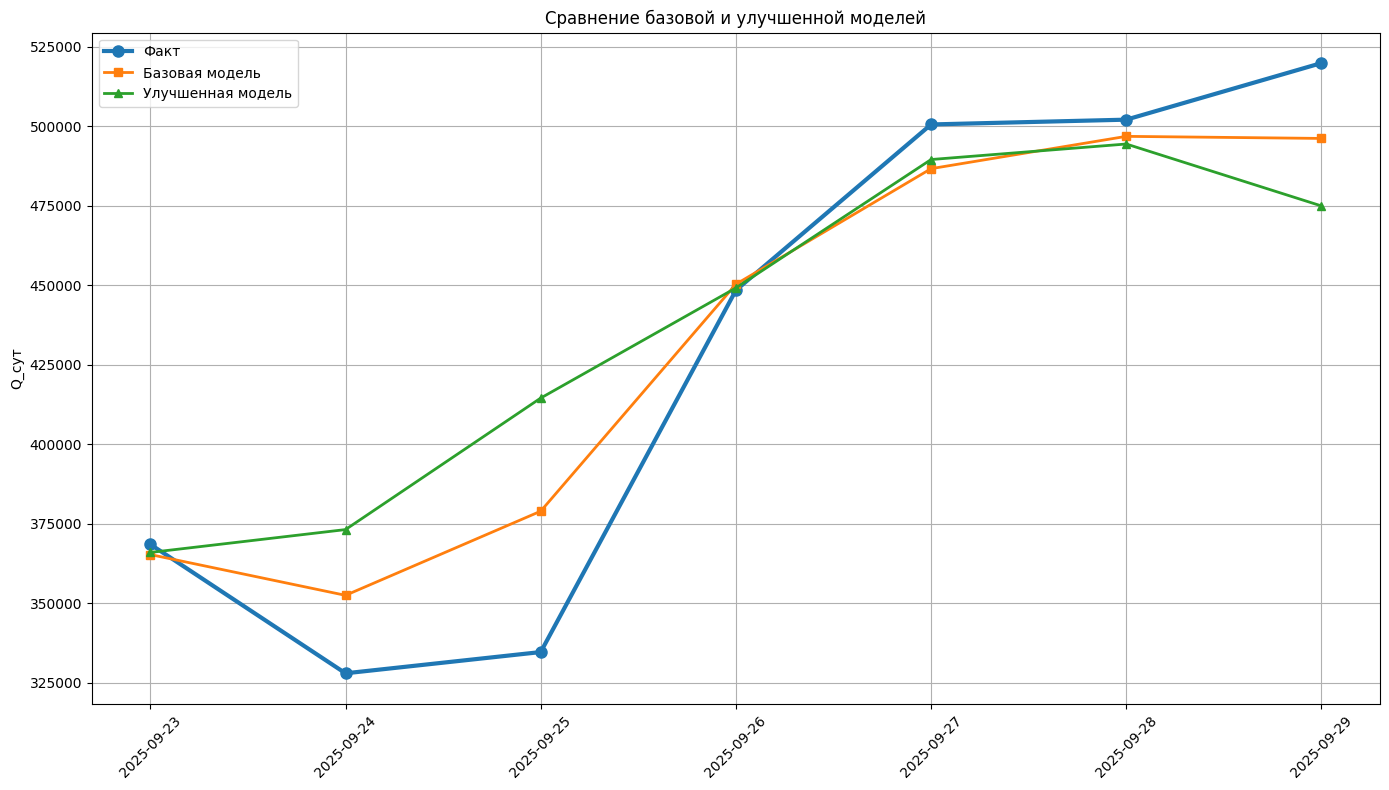


Топ-15 самых важных признаков в улучшенной модели:
              feature  importance
33          Темп_ma_7    0.635474
34         Темп_ma_14    0.155979
0   Т_воздуха_средняя    0.047484
2         Q_сут_lag_8    0.037431
3          Темп_lag_8    0.017170
31        Q_сут_ma_14    0.013660
32        Q_сут_ma_30    0.010380
5          Темп_lag_9    0.008928
40        day_of_year    0.008131
47       temp_anomaly    0.006194
4         Q_сут_lag_9    0.006131
1        Теплоемкость    0.005419
30         Q_сут_ma_7    0.004252
35         Темп_ma_30    0.004057
39       week_of_year    0.002989


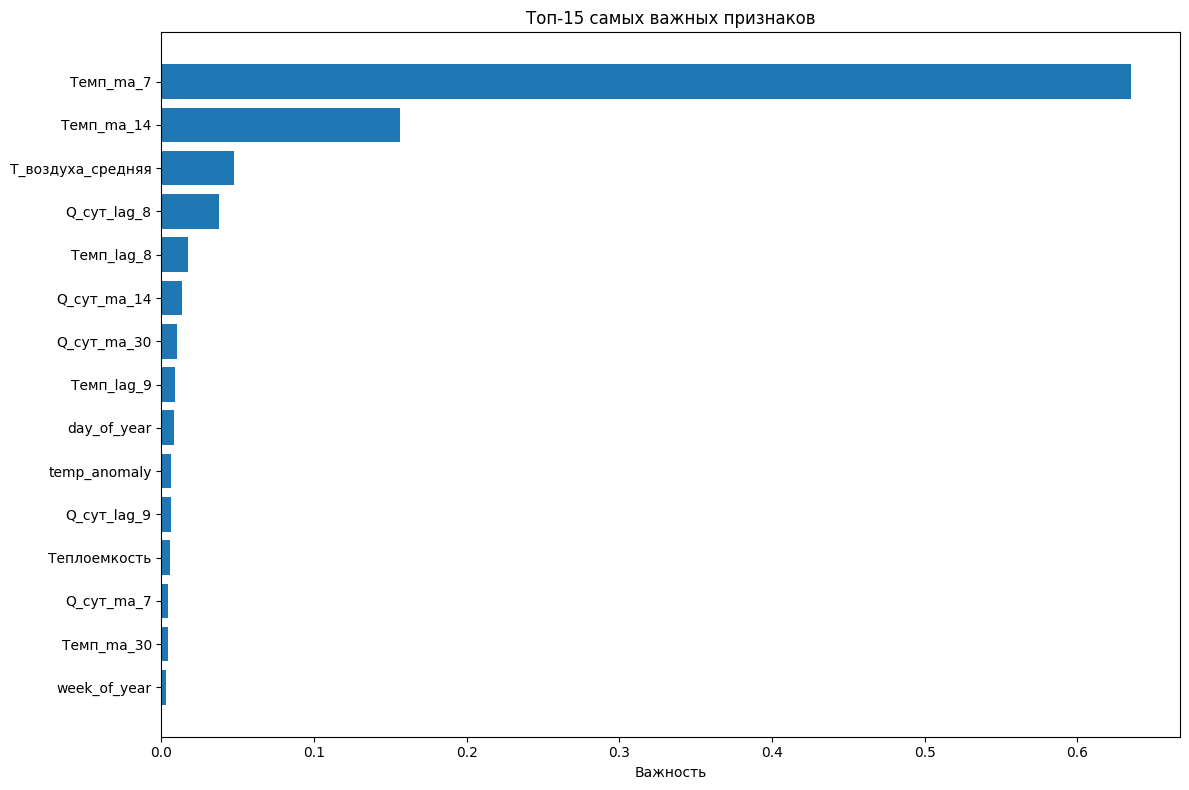


ПРИМЕР УЛУЧШЕННОГО ПРОГНОЗА ДЛЯ БУДУЩЕГО

Улучшенный прогноз на неделю с 2025-09-01:
Теплоемкость: 8340
Дата         |  Температура |  Прогноз Q_сут
---------------------------------------------
2025-09-01 |         15.0°C |         380983
2025-09-02 |         16.0°C |         374787
2025-09-03 |         14.0°C |         384384
2025-09-04 |         13.0°C |         389941
2025-09-05 |         12.0°C |         397553
2025-09-06 |         11.0°C |         400205
2025-09-07 |         10.0°C |         402788


{Timestamp('2025-09-01 00:00:00'): 380983.35,
 Timestamp('2025-09-02 00:00:00'): 374787.28,
 Timestamp('2025-09-03 00:00:00'): 384383.8,
 Timestamp('2025-09-04 00:00:00'): 389941.15,
 Timestamp('2025-09-05 00:00:00'): 397553.06,
 Timestamp('2025-09-06 00:00:00'): 400205.19,
 Timestamp('2025-09-07 00:00:00'): 402787.55}

In [25]:
def create_features_enhanced(df, target='Q_сут', min_lag=8, max_lag=21):
    """
    Создает улучшенные признаки со скользящими средними и сезонными паттернами
    """
    df = df.copy()
    
    # Базовые лаговые признаки
    for i in range(min_lag, max_lag + 1):
        df[f'Q_сут_lag_{i}'] = df[target].shift(i)
        df[f'Темп_lag_{i}'] = df['Т_воздуха_средняя'].shift(i)
    
    # === СКОЛЬЗЯЩИЕ СРЕДНИЕ ===
    
    # Скользящие средние расхода газа
    df['Q_сут_ma_7'] = df[target].shift(min_lag).rolling(window=7).mean()   # 7 дней
    df['Q_сут_ma_14'] = df[target].shift(min_lag).rolling(window=14).mean() # 14 дней
    df['Q_сут_ma_30'] = df[target].shift(min_lag).rolling(window=30).mean() # 30 дней
    
    # Скользящие средние температуры
    df['Темп_ma_7'] = df['Т_воздуха_средняя'].shift(min_lag).rolling(window=7).mean()
    df['Темп_ma_14'] = df['Т_воздуха_средняя'].shift(min_lag).rolling(window=14).mean()
    df['Темп_ma_30'] = df['Т_воздуха_средняя'].shift(min_lag).rolling(window=30).mean()
    
    # === СЕЗОННЫЕ ПРИЗНАКИ ===
    
    # Временные признаки
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['month'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week
    df['day_of_year'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['season'] = (df.index.month % 12 + 3) // 3  # 1-зима, 2-весна, 3-лето, 4-осень
    
    # Праздничные периоды (упрощенно)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    
    # === ДОПОЛНИТЕЛЬНЫЕ ПРИЗНАКИ ===
    
    # Волатильность расхода газа (стандартное отклонение за 7 дней)
    df['Q_сут_std_7'] = df[target].shift(min_lag).rolling(window=7).std()
    
    # Тренд температуры (разница между средней за 7 и 30 дней)
    df['temp_trend'] = df['Темп_ma_7'] - df['Темп_ma_30']
    
    # Отклонение от сезонной нормы
    df['temp_anomaly'] = df['Т_воздуха_средняя'] - df['Темп_ma_30']
    
    return df

# Функция для прогноза с улучшенными признаками
def forecast_next_week_enhanced(model, last_known_data, forecast_date, temperature_forecasts, heat_capacity):
    """
    Улучшенный прогноз со скользящими средними и сезонными признаками
    """
    predictions = {}
    
    if isinstance(forecast_date, str):
        forecast_date = pd.Timestamp(forecast_date)
    
    # Подготавливаем данные для расчета скользящих средних
    # Нам нужны данные за последние 30+ дней для расчета всех признаков
    required_days = 30 + 8  # 30 дней для скользящих средних + 8 дней лага
    
    for day in range(7):
        current_date = forecast_date + pd.Timedelta(days=day)
        
        features = {}
        
        # === БАЗОВЫЕ ЛАГИ ===
        for lag in range(8, 22):
            lag_date = current_date - pd.Timedelta(days=lag)
            if lag_date in last_known_data.index:
                features[f'Q_сут_lag_{lag}'] = last_known_data.loc[lag_date, 'Q_сут']
                features[f'Темп_lag_{lag}'] = last_known_data.loc[lag_date, 'Т_воздуха_средняя']
            else:
                # Используем ближайшие доступные данные
                available_dates = last_known_data[last_known_data.index <= lag_date]
                if len(available_dates) > 0:
                    nearest_date = available_dates.index.max()
                    features[f'Q_сут_lag_{lag}'] = last_known_data.loc[nearest_date, 'Q_сут']
                    features[f'Темп_lag_{lag}'] = last_known_data.loc[nearest_date, 'Т_воздуха_средняя']
                else:
                    features[f'Q_сут_lag_{lag}'] = last_known_data['Q_сут'].mean()
                    features[f'Темп_lag_{lag}'] = last_known_data['Т_воздуха_средняя'].mean()
        
        # === СКОЛЬЗЯЩИЕ СРЕДНИЕ ===
        # Для расчета нам нужны данные за последние 30+8 дней
        start_date_ma = current_date - pd.Timedelta(days=30+8)
        ma_data = last_known_data[last_known_data.index >= start_date_ma]
        
        if len(ma_data) >= 7:
            # Скользящие средние расхода газа
            features['Q_сут_ma_7'] = ma_data['Q_сут'].tail(7).mean()
            features['Q_сут_ma_14'] = ma_data['Q_сут'].tail(14).mean() if len(ma_data) >= 14 else ma_data['Q_сут'].mean()
            features['Q_сут_ma_30'] = ma_data['Q_сут'].tail(30).mean() if len(ma_data) >= 30 else ma_data['Q_сут'].mean()
            
            # Скользящие средние температуры
            features['Темп_ma_7'] = ma_data['Т_воздуха_средняя'].tail(7).mean()
            features['Темп_ma_14'] = ma_data['Т_воздуха_средняя'].tail(14).mean() if len(ma_data) >= 14 else ma_data['Т_воздуха_средняя'].mean()
            features['Темп_ma_30'] = ma_data['Т_воздуха_средняя'].tail(30).mean() if len(ma_data) >= 30 else ma_data['Т_воздуха_средняя'].mean()
            
            # Дополнительные признаки
            features['Q_сут_std_7'] = ma_data['Q_сут'].tail(7).std()
            features['temp_trend'] = features['Темп_ma_7'] - features['Темп_ma_30']
        else:
            # Если данных недостаточно, используем средние значения
            avg_q = last_known_data['Q_сут'].mean()
            avg_temp = last_known_data['Т_воздуха_средняя'].mean()
            features.update({
                'Q_сут_ma_7': avg_q, 'Q_сут_ma_14': avg_q, 'Q_сут_ma_30': avg_q,
                'Темп_ma_7': avg_temp, 'Темп_ma_14': avg_temp, 'Темп_ma_30': avg_temp,
                'Q_сут_std_7': last_known_data['Q_сут'].std(),
                'temp_trend': 0
            })
        
        # Аномалия температуры
        features['temp_anomaly'] = temperature_forecasts[current_date] - features['Темп_ma_30']
        
        # === СЕЗОННЫЕ ПРИЗНАКИ ===
        features['day_of_week'] = current_date.dayofweek
        features['is_weekend'] = 1 if current_date.dayofweek in [5, 6] else 0
        features['month'] = current_date.month
        features['week_of_year'] = current_date.isocalendar().week
        features['day_of_year'] = current_date.dayofyear
        features['quarter'] = current_date.quarter
        features['season'] = (current_date.month % 12 + 3) // 3
        features['is_winter'] = 1 if current_date.month in [12, 1, 2] else 0
        features['is_summer'] = 1 if current_date.month in [6, 7, 8] else 0
        
        # === БАЗОВЫЕ ПРИЗНАКИ ===
        features['Теплоемкость'] = heat_capacity
        features['Т_воздуха_средняя'] = temperature_forecasts[current_date]
        
        # Создаем DataFrame с правильным порядком признаков
        features_df = pd.DataFrame([features])[model.feature_names_in_]
        
        # Прогнозируем
        prediction = model.predict(features_df)[0]
        predictions[current_date] = prediction
    
    return predictions

# Создаем улучшенные признаки и обучаем модель
print("Создаем улучшенные признаки...")
daily_df_enhanced = create_features_enhanced(daily_df, min_lag=8, max_lag=21)
daily_df_enhanced = daily_df_enhanced.dropna()

print(f"Новые признаки: {[col for col in daily_df_enhanced.columns if col not in ['Q_сут', 'Теплоемкость']]}")

X_enhanced = daily_df_enhanced.drop(['Q_сут'], axis=1)
y_enhanced = daily_df_enhanced['Q_сут']

print(f"Размерность улучшенных данных: {X_enhanced.shape}")

# Обучаем улучшенную модель
model_enhanced = RandomForestRegressor(n_estimators=100, random_state=42)
model_enhanced.fit(X_enhanced, y_enhanced)

# Сравниваем качество моделей
def compare_models():
    """Сравнивает базовую и улучшенную модели"""
    
    # Тестируем на последней неделе данных
    last_date = daily_df.index[-1]
    week_start = last_date - pd.Timedelta(days=6)
    
    # Подготовка данных
    temperature_forecasts = {}
    for day in range(7):
        current_date = week_start + pd.Timedelta(days=day)
        temperature_forecasts[current_date] = daily_df.loc[current_date, 'Т_воздуха_средняя']
    
    data_before_week = daily_df.loc[:week_start - pd.Timedelta(days=1)]
    heat_capacity = daily_df['Теплоемкость'].iloc[-1]
    
    # Прогноз базовой моделью
    predictions_basic = forecast_next_week_with_custom_params(
        model_weekly, data_before_week, week_start, temperature_forecasts, heat_capacity
    )
    
    # Прогноз улучшенной моделью
    predictions_enhanced = forecast_next_week_enhanced(
        model_enhanced, data_before_week, week_start, temperature_forecasts, heat_capacity
    )
    
    # Собираем фактические значения
    actual_values = {}
    for date in predictions_basic.keys():
        if date in daily_df.index:
            actual_values[date] = daily_df.loc[date, 'Q_сут']
    
    # Сравниваем метрики
    dates = sorted(actual_values.keys())
    actual_list = [actual_values[date] for date in dates]
    pred_basic_list = [predictions_basic[date] for date in dates]
    pred_enhanced_list = [predictions_enhanced[date] for date in dates]
    
    mae_basic = mean_absolute_error(actual_list, pred_basic_list)
    mae_enhanced = mean_absolute_error(actual_list, pred_enhanced_list)
    
    rmse_basic = np.sqrt(mean_squared_error(actual_list, pred_basic_list))
    rmse_enhanced = np.sqrt(mean_squared_error(actual_list, pred_enhanced_list))
    
    print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
    print(f"{'Метрика':10} | {'Базовая':>10} | {'Улучшенная':>10} | {'Улучшение':>10}")
    print("-" * 55)
    print(f"{'MAE':10} | {mae_basic:10.0f} | {mae_enhanced:10.0f} | {(mae_basic-mae_enhanced)/mae_basic*100:9.1f}%")
    print(f"{'RMSE':10} | {rmse_basic:10.0f} | {rmse_enhanced:10.0f} | {(rmse_basic-rmse_enhanced)/rmse_basic*100:9.1f}%")
    
    # Визуализация сравнения
    plt.figure(figsize=(14, 8))
    
    plt.plot(dates, actual_list, 'o-', label='Факт', linewidth=3, markersize=8)
    plt.plot(dates, pred_basic_list, 's-', label='Базовая модель', linewidth=2, markersize=6)
    plt.plot(dates, pred_enhanced_list, '^-', label='Улучшенная модель', linewidth=2, markersize=6)
    
    plt.title('Сравнение базовой и улучшенной моделей')
    plt.ylabel('Q_сут')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predictions_basic, predictions_enhanced, actual_values

# Запускаем сравнение
basic_pred, enhanced_pred, actuals = compare_models()

# Анализ важности признаков в улучшенной модели
feature_importance_enhanced = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': model_enhanced.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-15 самых важных признаков в улучшенной модели:")
print(feature_importance_enhanced.head(15))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
top_features = feature_importance_enhanced.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Важность')
plt.title('Топ-15 самых важных признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Пример использования улучшенной модели для будущего прогноза
print("\n" + "="*60)
print("ПРИМЕР УЛУЧШЕННОГО ПРОГНОЗА ДЛЯ БУДУЩЕГО")
print("="*60)

def enhanced_quick_forecast(start_date, temperatures, heat_capacity):
    """Быстрый прогноз с улучшенной моделью"""
    start_date = pd.Timestamp(start_date)
    temp_forecasts = {}
    for i, temp in enumerate(temperatures):
        date = start_date + pd.Timedelta(days=i)
        temp_forecasts[date] = temp
    
    predictions = forecast_next_week_enhanced(
        model_enhanced,
        daily_df,
        start_date,
        temp_forecasts,
        heat_capacity
    )
    
    print(f"\nУлучшенный прогноз на неделю с {start_date.strftime('%Y-%m-%d')}:")
    print(f"Теплоемкость: {heat_capacity}")
    print(f"{'Дата':12} | {'Температура':>12} | {'Прогноз Q_сут':>14}")
    print("-" * 45)
    for date in sorted(predictions.keys()):
        pred = predictions[date]
        temp = temp_forecasts[date]
        print(f"{date.strftime('%Y-%m-%d')} | {temp:12.1f}°C | {pred:14.0f}")
    
    return predictions

# Пример прогноза
enhanced_quick_forecast(
    start_date='2025-09-01',
    temperatures=[15.0, 16.0, 14.0, 13.0, 12.0, 11.0, 10.0],
    heat_capacity=8340
)